------
-----


In [ ]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale = 2)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle
from lightgbm import LGBMRegressor

In [ ]:
cus = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/cus_info.csv")
iem = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/iem_info_20210902.csv")
hist = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/stk_bnc_hist.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/stk_hld_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/stk_hld_test.csv")
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open/sample_submission.csv")

 - 이 대회는 2020년 12월 31일 이전에 매수한 상품을 언제 매도할지를 예측하는 대회입니다.
 
 - train 데이터의 'hold_d' 컬럼은 2021년 이전에 매도가 종료된 데이터만 존재하고, 2021년 이전에 사서 투자중인 데이터는 test 데이터로 넘어왔습니다.

 - 2020년 12월 31일에 주식을 사서 그 다음 개장일인 2021년 1월 4일에 팔았다고 하여도 최소 보유기간은 2일입니다. 그리하여 train에서 보유기간이 1일 이하인 데이터는 drop을 하였습니다.


In [ ]:
train = train.drop(train[train['hold_d'] <= 1].index)

- 'A'라는 사람이 2021년 이전에 단타를 주로 쳤다고하여 test 데이터에 존재하는 'A'가 가진 상품을 빨리 팔것이라 예측하는 것이 적합한지에 대한 의문을 가졌습니다.

- 왜냐하면 2021년 이후에 구매한 상품의 매도일을 예측하는 것이 아닌 2021년 이전에 구매한 상품을 2021년 이후 언제 매도할지 예측하는 것이기 때문입니다.

- 위와같은 데이터가 지닌 특성으로 인해 train 데이터에 비해 test 데이터에 장기 투자중인 상품이 많이 있을 것이라 판단하였습니다.

- 그리하여 train의 hold_d 컬럼을 기준으로 단타 데이터를 포함하여 학습한 모델, 단타 데이터를 제외하여 학습한 모델을 따로 만들었습니다.

In [ ]:
idx_0 = train[train.hold_d <= 30].index
idx_1 = train[train.hold_d > 30].index
idx_2 = train[train.hold_d > 146].index

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])
nb_2 = len(train.loc[idx_2])

print("train에서 'hold_d' 컬럼값이 30일 이하인 data 수 : {}".format(nb_0))
print("train에서 'hold_d' 컬럼값이 31일 이상인 data 수 : {}".format(nb_1))
print("train에서 'hold_d' 컬럼값이 147일 이상인 data 수 : {}".format(nb_2))

train에서 'hold_d' 컬럼값이 30일 이하인 data 수 : 394931
train에서 'hold_d' 컬럼값이 31일 이상인 data 수 : 96533
train에서 'hold_d' 컬럼값이 147일 이상인 data 수 : 17454


In [ ]:
train_2 = train.loc[idx_1].reset_index(drop=True)

In [ ]:
#정보제공 미동의(0)와 미정의(99)를 결측치로 보고 합쳐서 6으로 치환
cus.loc[(cus['ivs_icn_cd'] == 99) | (cus['ivs_icn_cd'] == 0), 'ivs_icn_cd'] = 6

In [ ]:
data = pd.merge(train, cus, how = "left", on = ["act_id"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


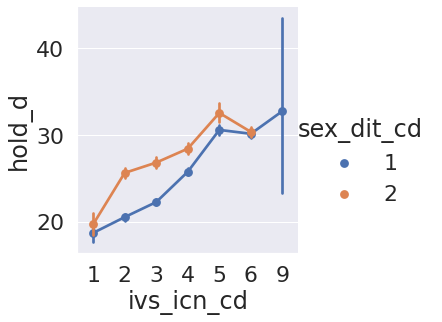

In [ ]:
sns.factorplot('ivs_icn_cd', 'hold_d', hue = 'sex_dit_cd', data = data)
plt.show()

- factorplot을 이용하여 성별을 구분하여 투자성향에 따른 보유기간을 보니 확실히 투자성향이 안전적인 투자에서 공격적인 투자로 갈수록 보유 기간이 증가함을 알 수 있습니다.

- 즉, **보유기간을 예측하는데에 중요한 feature로 판단되었습니다.**

- 위 plot에서 전문투자자형을 제외하고는 분산이 굉장히 적은 것을 확인할 수 있습니다. 

- 결측치에 해당하는 6과 5의 hold_d평균이 굉장히 비슷하기 때문에 6인 사람들을 5로 치환해주었습니다.

In [ ]:
#정보제공 미동의(0)와 미정의(99)를 결측치로 보고 합쳐서 5로 치환
cus.loc[(cus['ivs_icn_cd'] == 6), 'ivs_icn_cd'] = 5

In [ ]:
iem['stk_dit_cd'].value_counts()

99    2728
1      201
2      150
Name: stk_dit_cd, dtype: int64

In [ ]:
missings = iem[iem['stk_dit_cd'] == 99]['stk_dit_cd'].count()
print(missings)
misssings_perc = missings / iem.shape[0]
print('missing percent : {:.2%}'.format(misssings_perc))

2728
missing percent : 88.60%


- stk_dit_cd 컬럼은 결측치가 너무 많기 때문에 drop.

In [ ]:
train.shape

(491464, 4)

In [ ]:
train_2.shape

(96533, 4)

In [ ]:
data_1 = pd.concat([train, test, cus, hist], axis = 0)
data_2 = pd.concat([train_2, test, cus, hist], axis = 0)

L_encoder = LabelEncoder()
data_1['act_id'] = L_encoder.fit_transform(data_1['act_id'])
data_2['act_id'] = L_encoder.fit_transform(data_2['act_id'])

train = data_1[['act_id', 'iem_cd', 'byn_dt', 'hold_d']][0:train.shape[0]]
test = data_1[['act_id', 'iem_cd', 'byn_dt','hist_d', 'submit_id', 'hold_d']][train.shape[0]:train.shape[0]+test.shape[0]]
cus = data_1[['act_id', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']][train.shape[0]+test.shape[0] : train.shape[0]+test.shape[0]+cus.shape[0]]
hist = data_1[['act_id', 'bse_dt', 'iem_cd', 'bnc_qty', 'tot_aet_amt', 'stk_par_pr']][train.shape[0]+test.shape[0]+cus.shape[0]:]

train_2 = data_2[['act_id', 'iem_cd', 'byn_dt', 'hold_d']][0:train_2.shape[0]]
test_2 = data_2[['act_id', 'iem_cd', 'byn_dt','hist_d', 'submit_id', 'hold_d']][train_2.shape[0]:train_2.shape[0]+test.shape[0]]
cus_2 = data_2[['act_id', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd']][train_2.shape[0]+test.shape[0] : train_2.shape[0]+test.shape[0]+cus.shape[0]]
hist_2 = data_2[['act_id', 'bse_dt', 'iem_cd', 'bnc_qty', 'tot_aet_amt', 'stk_par_pr']][train_2.shape[0]+test.shape[0]+cus.shape[0]:]


- act_id 컬럼을 라벨인코딩해주었습니다.

In [ ]:
train_data = pd.merge(train, cus, how = "left", on = ["act_id"])
train_data = pd.merge(train_data, iem, how = "left", on = ["iem_cd"])

test_data = pd.merge(test, cus, how = "left", on = ["act_id"])
test_data = pd.merge(test_data, iem, how = "left", on = ["iem_cd"])

In [ ]:
train_data2 = pd.merge(train_2, cus_2, how = "left", on = ["act_id"])
train_data2 = pd.merge(train_data2, iem, how = "left", on = ["iem_cd"])

test_data2 = pd.merge(test_2, cus_2, how = "left", on = ["act_id"])
test_data2 = pd.merge(test_data2, iem, how = "left", on = ["iem_cd"])

In [ ]:
hist = hist.fillna(0)

train_data = pd.merge(train_data, hist, how = "left", on = ["act_id", "iem_cd"])
train_data = train_data[(train_data["byn_dt"] == train_data["bse_dt"])]
train_data.reset_index(drop = True, inplace = True)

test_data = pd.merge(test_data, hist, how = "left", on = ["act_id", "iem_cd"])
test_data = test_data[(test_data["byn_dt"] == test_data["bse_dt"])]
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["iem_cd", "byn_dt", "bse_dt", "stk_par_pr", "cus_age_stn_cd", "tco_cus_grd_cd", "bnc_qty", "tot_aet_amt", "stk_dit_cd", "mkt_pr_tal_scl_tp_cd"], axis = 1)
test_data = test_data.drop([ "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt", "stk_par_pr", "cus_age_stn_cd", "tco_cus_grd_cd", "bnc_qty", "tot_aet_amt", "stk_dit_cd", "mkt_pr_tal_scl_tp_cd"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data["iem_krl_nm"] = L_encoder.transform(train_data["iem_krl_nm"])
test_data["iem_krl_nm"] = L_encoder.transform(test_data["iem_krl_nm"])

In [ ]:
hist_2 = hist_2.fillna(0)

train_data2 = pd.merge(train_data2, hist_2, how = "left", on = ["act_id", "iem_cd"])
train_data2= train_data2[(train_data2["byn_dt"] == train_data2["bse_dt"])]
train_data2.reset_index(drop = True, inplace = True)

test_data2 = pd.merge(test_data2, hist_2, how = "left", on = ["act_id", "iem_cd"])
test_data2 = test_data2[(test_data2["byn_dt"] == test_data2["bse_dt"])]
test_data2.reset_index(drop = True, inplace = True)

train_data2 = train_data2.drop(["iem_cd", "byn_dt", "bse_dt", "stk_par_pr", "cus_age_stn_cd", "tco_cus_grd_cd", "bnc_qty", "tot_aet_amt", "stk_dit_cd", "mkt_pr_tal_scl_tp_cd"], axis = 1)
test_data2 = test_data2.drop([ "iem_cd", "byn_dt", "submit_id", "hold_d", "bse_dt", "stk_par_pr", "cus_age_stn_cd", "tco_cus_grd_cd", "bnc_qty", "tot_aet_amt", "stk_dit_cd", "mkt_pr_tal_scl_tp_cd"], axis = 1)

L_encoder = LabelEncoder()
L_encoder.fit(iem["iem_krl_nm"])
train_data2["iem_krl_nm"] = L_encoder.transform(train_data2["iem_krl_nm"])
test_data2["iem_krl_nm"] = L_encoder.transform(test_data2["iem_krl_nm"])

In [ ]:
idx1 = test_data[test_data.hist_d <= 30].index
idx1_list = list(idx1)

idx2 = test_data[test_data.hist_d > 30].index
idx2_list = list(idx2)

test_data_1 = test_data.loc[idx1_list].reset_index(drop=True)
test_data_2 = test_data.loc[idx2_list].reset_index(drop=True)
print(test_data_1.shape)
print(test_data_2.shape)

(28853, 11)
(41743, 11)


- test의 hist_d 컬럼을 기준으로 30일 이하의 데이터는 단타 데이터를 포함하여 학습한 모델로 예측하고 30일 초과의 데이터는 단타 데이터를 제외하여 학습한 모델로 예측하였습니다. 

In [ ]:
train_label = train_data["hold_d"]
train_label2 = train_data2["hold_d"]
train_data.drop(["hold_d"], axis = 1, inplace = True)
train_data2.drop(["hold_d"], axis = 1, inplace = True)

test_data_1.drop(["hist_d"], axis = 1, inplace = True)
test_data_2.drop(["hist_d"], axis = 1, inplace = True)

In [ ]:
train_data.reset_index(drop = True, inplace = True)
train_data2.reset_index(drop = True, inplace = True)

test_data_1.reset_index(drop = True, inplace = True)
test_data_2.reset_index(drop = True, inplace = True)

- 모델은 lgbm regressor를 이용하였습니다.

In [ ]:
models = []

folds = KFold(n_splits = 10)

for train_idx, val_idx in folds.split(train_data):

  train_x = train_data.iloc[train_idx, :]
  train_y = train_label[train_idx]

  val_x = train_data.iloc[val_idx, :]
  val_y = train_label.iloc[val_idx]

  model = LGBMRegressor(objective = "regression",
                        max_depth = 5,
                        n_estimators = 2000,
                        learning_rate = 0.01,
                        num_leaves = 31)
  
  model.fit(train_x, train_y,
            eval_set = [(val_x, val_y)],
            eval_metric = ["rmse"],
            early_stopping_rounds = 500,
            verbose = 500)
  
  models.append(model)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 5499.9	valid_0's rmse: 74.1613
Early stopping, best iteration is:
[127]	valid_0's l2: 5467.57	valid_0's rmse: 73.943
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 6707.35	valid_0's rmse: 81.8984
Early stopping, best iteration is:
[494]	valid_0's l2: 6707.05	valid_0's rmse: 81.8966
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 7406.58	valid_0's rmse: 86.0615
Early stopping, best iteration is:
[492]	valid_0's l2: 7406.34	valid_0's rmse: 86.0601
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 5093.86	valid_0's rmse: 71.3713
[1000]	valid_0's l2: 5088.45	valid_0's rmse: 71.3334
[1500]	valid_0's l2: 5087.36	valid_0's rmse: 71.3257
Early stopping, best iteration is:
[1468]	valid_0's l2: 5086.48	valid_0's rmse: 71.3196
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 4099

In [ ]:
models2 = []

folds = KFold(n_splits = 7)

for train_idx, val_idx in folds.split(train_data2):

  train_x = train_data2.iloc[train_idx, :]
  train_y = train_label2[train_idx]

  val_x = train_data2.iloc[val_idx, :]
  val_y = train_label2.iloc[val_idx]

  model = LGBMRegressor(objective = "regression",
                        max_depth = 5,
                        n_estimators = 2000,
                        learning_rate = 0.01,
                        num_leaves = 31)
  
  model.fit(train_x, train_y,
            eval_set = [(val_x, val_y)],
            eval_metric = ["rmse"],
            early_stopping_rounds = 500,
            verbose = 500)
  
  models2.append(model)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 15745	valid_0's rmse: 125.479
Early stopping, best iteration is:
[247]	valid_0's l2: 15654.4	valid_0's rmse: 125.118
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 20210.4	valid_0's rmse: 142.163
[1000]	valid_0's l2: 20135.5	valid_0's rmse: 141.9
[1500]	valid_0's l2: 20129.3	valid_0's rmse: 141.878
Early stopping, best iteration is:
[1229]	valid_0's l2: 20108.7	valid_0's rmse: 141.805
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 16729	valid_0's rmse: 129.34
Early stopping, best iteration is:
[54]	valid_0's l2: 16603.8	valid_0's rmse: 128.856
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 11006.7	valid_0's rmse: 104.913
Early stopping, best iteration is:
[18]	valid_0's l2: 10845.8	valid_0's rmse: 104.143
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 7196.27	val

In [ ]:
result = []
for i in models:
  result.append(i.predict(test_data_1))
predict = np.mean(result, axis = 0)

In [ ]:
result2 = []
for i in models2:
  result2.append(i.predict(test_data_2))
predict2 = np.mean(result2, axis = 0)

In [ ]:
for i in predict:
  if i > 146:
    i = 146

for i in predict2:
  if i > 146:
    i = 146

In [ ]:
idx_0 = test[test.hist_d <= 30].index
idx_1 = test[test.hist_d > 30].index

predict_1 = predict + test.loc[idx_0]['hist_d']
predict_2 = predict2 + test.loc[idx_1]['hist_d']

submission.loc[predict_1.index, "hold_d"] = predict_1.loc[predict_1.index]
submission.loc[predict_2.index, "hold_d"] = predict_2.loc[predict_2.index]

submission.to_csv("/content/drive/MyDrive/Colab Notebooks/open/dacon_baseline2.csv", index = False)